# Stable Diffusion classic fine tuning
> Classic fine tuning example, aka native text2image training for whole model    
* Training used multiple gpus of ml.g5.12xlarge(4 x NVIDIA A10G), you can also use single GPU instance by removing "--multi_gpu" flag in training scripts
* Training used [Linaqruf's hitokomoru dataset](https://huggingface.co/datasets/Linaqruf/locon-dataset/tree/main), total 98 pictures (regarding how to prepare such dataset, see [content from kohya-ss github](https://github.com/kohya-ss/sd-scripts/blob/main/docs/train_README-ja.md#%E3%83%A1%E3%82%BF%E3%83%87%E3%83%BC%E3%82%BF%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%AE%E4%BD%9C%E6%88%90))
* Training scripts used ["fine_tune.py" from repo of kohya-ss](https://github.com/kohya-ss/sd-scripts), images were processed by [Aspect Ratio Bucketing](https://github.com/NovelAI/novelai-aspect-ratio-bucketing)
* Docker image for SageMaker's training job was built by the method of [extending a pre-built container](https://docs.aws.amazon.com/sagemaker/latest/dg/prebuilt-containers-extend.html)
* ml.t3.medium notebook instance is good enough to run codes, configure storage with 100GB+, because we need to build large docker images for training job
* You need to register your [WanDB](https://wandb.ai) account first to get its api-key accordingly, and modify `'wandb_api_key': 'input_your_wandb_api-key'` in hyperparameters of training scripts, or you can comment it out if you prefer not to monitor your training precess

## 1. Prepare training dataset

In [ ]:
# If you don't want to use kohya's tools to process training data, you can skip below 

!git clone https://github.com/kohya-ss/sd-scripts
%cd sd-scripts/
!pip install -U -r requirements.txt

In [2]:
TRAIN_DATA_DIR = "./images"
!mkdir -p $TRAIN_DATA_DIR

In [3]:
!wget -q https://huggingface.co/datasets/Linaqruf/locon-dataset/resolve/main/hitokomoru_locon_dataset.zip

In [4]:
import os
import shutil
import zipfile

zip_file = 'hitokomoru_locon_dataset.zip'
target_dir = TRAIN_DATA_DIR
temp_dir = target_dir+'/temp'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

bottom_dir = None
for root, dirs, files in os.walk(temp_dir):
    if not dirs:
        if bottom_dir is None:
            bottom_dir = root
        elif len(root.split(os.sep)) > len(bottom_dir.split(os.sep)):
            bottom_dir = root
        
for root, dirs, files in os.walk(bottom_dir):
    for file in files:
        if not file.endswith('.npz'):
            source_file = os.path.join(root, file)
            target_file = os.path.join(target_dir, file)
            shutil.copy(source_file, target_file)
    
shutil.rmtree(temp_dir)
os.remove('./hitokomoru_locon_dataset.zip')

In [ ]:
!python ./finetune/merge_captions_to_metadata.py --full_path $TRAIN_DATA_DIR $TRAIN_DATA_DIR/meta_cap.json

In [ ]:
!python ./finetune/merge_dd_tags_to_metadata.py --full_path $TRAIN_DATA_DIR --in_json $TRAIN_DATA_DIR/meta_cap.json $TRAIN_DATA_DIR/meta_cap_dd.json

In [ ]:
!python ./finetune/clean_captions_and_tags.py $TRAIN_DATA_DIR/meta_cap_dd.json $TRAIN_DATA_DIR/meta_clean.json

In [8]:
# Modify directories of metadata json-file for adapting sagemaker training job

import json

with open('./images/meta_clean.json', 'r') as f:
    data = json.load(f)
    
for key in list(data.keys()):
    if key.startswith('images/'):
        value = data[key]
        del data[key]
        new_key = key.replace('images/', '/opt/ml/input/data/images/')
        data[new_key] = value    
    
with open('./images/meta_clean.json', 'w') as f:
    json.dump(data, f)

## 2. Prepare Dockerfile and configurations for building docker image   

In [ ]:
%%writefile ./images/dataset.toml
[general]
enable_bucket = true
shuffle_caption = true
keep_tokens = 0
# color_aug = true

# Classic fine tuning based datasets
[[datasets]]
resolution = 768
batch_size = 4
max_bucket_reso = 1280

  [[datasets.subsets]]
  metadata_file = '/opt/ml/input/data/images/meta_clean.json'

In [ ]:
%%writefile ./images/sample_prompts.txt
# prompt 1
1girl, solo, sitting, confident expression, long blonde hair, blue eyes, formal dress, jewelry, make-up, luxury, upper body, masterpiece, best quality, highly detailed --n lowres, worst quality, ugly, extra limbs, deformed legs, disfigured legs, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), text, logo, watermark --w 512 --h 768 --d 12345 --l 7.5 --s 20

# # prompt 2
1girl, solo, sitting, confident expression, long blonde hair, blue eyes, formal dress, jewelry, make-up, luxury, upper body, masterpiece, best quality, highly detailed --n lowres, worst quality, ugly, extra limbs, deformed legs, disfigured legs, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), text, logo, watermark --w 512 --h 768 --d 67890 --l 7.5 --s 20


In [ ]:
%%writefile Dockerfile
FROM 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:2.0.0-gpu-py310-cu118-ubuntu20.04-sagemaker

ENV PATH="/opt/ml/code:${PATH}"
ENV SAGEMAKER_SUBMIT_DIRECTORY /opt/ml/code
ENV DEBIAN_FRONTEND noninteractive

RUN pip install xformers==0.0.18 dadaptation lion-pytorch wandb && \
    git clone https://github.com/kohya-ss/sd-scripts /opt/ml/code

WORKDIR /opt/ml/code

RUN mv fine_tune.py fine_tune && \
    sed -i '/opencv/d' requirements.txt && \
    pip install -U -r requirements.txt 
# RUN mkdir -p images/

# COPY ./images/* ./images/

WORKDIR /

ENV SAGEMAKER_PROGRAM accelerate.commands.launch --multi_gpu fine_tune

## 3. Change default docker-root-dir of SageMaker notebook
> Default docker-root-dir of SageMaker notebook has limited space, which is not big enough for building large images

In [ ]:
!sudo service docker stop
!mkdir -p ~/SageMaker/docker-root
!sudo mv /var/lib/docker ~/SageMaker/docker-root
!sudo ln -s ~/SageMaker/docker-root/docker /var/lib/docker
!sudo service docker start

## 4. Build docker image and push to ECR

In [ ]:
%%sh

# Specify an algorithm name
algorithm_name=sd-classic-finetuning-job

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"
base_image_repo="763104351884.dkr.ecr.${region}.amazonaws.com"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1
if [ $? -ne 0 ]
then
aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly

aws ecr get-login-password --region ${region}|docker login --username AWS --password-stdin ${fullname}
aws ecr get-login-password --region ${region}|docker login --username AWS --password-stdin ${base_image_repo}

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

## 5. Train models with SageMaker training job

In [15]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name
images_s3uri = 's3://{0}/train-dataset/images/'.format(bucket)

In [ ]:
# Copy training dataset to S3 bucket

!aws s3 cp images $images_s3uri --recursive

In [ ]:
import json
def json_encode_hyperparameters(hyperparameters):
    for (k, v) in hyperparameters.items():
        print(k, v)
    return {k: json.dumps(v) for (k, v) in hyperparameters.items()}

docker_image_uri = '{0}.dkr.ecr.{1}.amazonaws.com/sd-classic-finetuning-job'.format(account_id, region_name)
instance_type = 'ml.g5.12xlarge'

base_model_name="runwayml/stable-diffusion-v1-5"
output_dir="/opt/ml/model/"

hyperparameters = {
                    'pretrained_model_name_or_path': base_model_name,
                    'output_dir': output_dir,
                    'output_name': 'classic_finetune_hitokomoru_sd15',
                    'dataset_config': '/opt/ml/input/data/images/dataset.toml',
                    'learning_rate': 1e-5,
                    'max_train_steps': 3000,
                    'clip_skip': 2,
                    'max_token_length': 225,
                    'save_every_n_steps': 600,
                    'xformers': '',
                    'optimizer_type': 'AdamW8bit',
                    'gradient_checkpointing': '',
                    'mixed_precision': 'fp16',
                    'cache_latents_to_disk': '',
                    'sample_every_n_steps': 600,
                    'sample_prompts': '/opt/ml/input/data/images/sample_prompts.txt',
                    'sample_sampler': 'euler_a',
                    'logging_dir': '/opt/ml/code/logs',
                    'log_with': 'all',
                    'log_tracker_name': 'classic_finetune_hitokomoru_sd15',
                    'wandb_api_key': 'input_your_wandb_api-key'
}

hyperparameters = json_encode_hyperparameters(hyperparameters)

In [ ]:
from sagemaker.estimator import Estimator

inputs = {
    'images': images_s3uri
}

estimator = Estimator(
    role = role,
    instance_count=1,
    instance_type = instance_type,
    image_uri = docker_image_uri,
    hyperparameters = hyperparameters
)
estimator.fit(inputs)

In [ ]:
model_data = estimator.model_data
print("Model artifact saved at:\n", model_data)

## 6. Deploy a model to SageMaker's inference endpoint for testing

In [ ]:
!mkdir outputs
!aws s3 cp $model_data ./outputs
!tar -zvxf ./outputs/model.tar.gz -C ./outputs
!rm ./outputs/model.tar.gz

In [ ]:
!pip install natsort

In [ ]:
from natsort import natsorted
from glob import glob
import os
WEIGHTS_DIR = natsorted(glob("./outputs" + os.sep + "*"))[0]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}") 

In [ ]:
!mkdir -p $WEIGHTS_DIR/code

In [ ]:
%%writefile $WEIGHTS_DIR/code/requirements.txt
diffusers
transformers>=4.25.1

In [ ]:
%%writefile $WEIGHTS_DIR/code/inference.py
import base64
import torch
from io import BytesIO
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler


def model_fn(model_dir):
    
    # Load stable diffusion and move it to the GPU
    scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
    pipe = StableDiffusionPipeline.from_pretrained(model_dir, scheduler=scheduler, torch_dtype=torch.float16)
    # pipe = StableDiffusionPipeline.from_pretrained(model_dir, custom_pipeline="lpw_stable_diffusion", scheduler=scheduler, torch_dtype=torch.float16) # Add custom pipeline to support long prompt
    pipe = pipe.to("cuda")

    return pipe


def encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale):
    
    generator = generator.manual_seed(seed)
    generated_images = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator = generator
    )["images"][0]
    buffered = BytesIO()
    generated_images.save(buffered, format="PNG")
    encoded_image_response = base64.b64encode(buffered.getvalue()).decode()
    
    return encoded_image_response


def predict_fn(data, pipe):
    
    generator = torch.Generator(device="cuda")
    
    # get prompt & parameters
    prompt = data.pop("prompt", "")
    negative_prompt = data.pop("negative_prompt", "")
    # set valid HP for stable diffusion
    height = data.pop("height", 512)
    width = data.pop("width", 512)
    num_inference_steps = data.pop("num_inference_steps", 20)
    guidance_scale = data.pop("guidance_scale", 7.5)
    num_images_per_prompt = data.pop("num_images_per_prompt", 2)
    seed = data.pop("seed", "")
    
    seeds = []
    encoded_images = []
    
    # run generation with parameters
    if seed:
        seeds.append(seed)
        encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
        encoded_images.append(encoded_image_rt)
        for _ in range(num_images_per_prompt-1):
            seed=seed+1
            seeds.append(seed)
            encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
            encoded_images.append(encoded_image_rt)
    else:
        for _ in range(num_images_per_prompt):
            seed = generator.seed()
            seeds.append(seed)
            encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
            encoded_images.append(encoded_image_rt)

    # create response
    return {"generated_images": encoded_images, "seeds": seeds}

In [ ]:
!tar --exclude *.ckpt --exclude *.tar.gz --use-compress-program=pigz -pcvf $WEIGHTS_DIR/model.tar.gz -C $WEIGHTS_DIR/ .

In [ ]:
from sagemaker.s3 import S3Uploader
s3_model_uri=S3Uploader.upload(local_path=f"{WEIGHTS_DIR}/model.tar.gz", desired_s3_uri=f"s3://{sagemaker_session.default_bucket()}/model/classic-finetune")

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,      # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.17",  # transformers version used
   pytorch_version="1.10",       # pytorch version used
   py_version='py38',            # python version used
)

# deploy the endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge"
    )

In [ ]:
from PIL import Image
from io import BytesIO
import base64
import datetime

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)

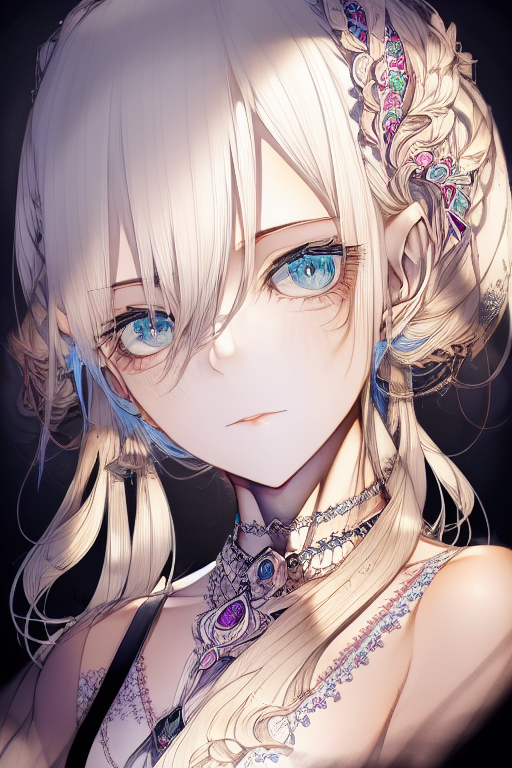

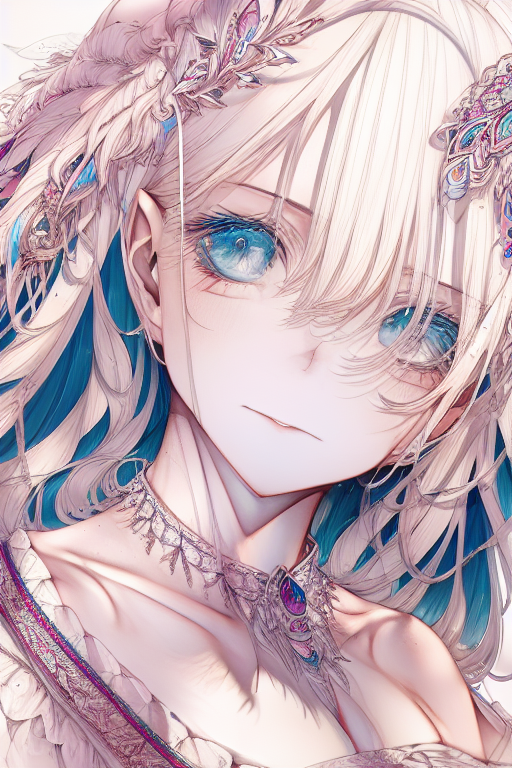


Seeds for generating images: [6718847382386216, 7187133231440364]


In [33]:
# run prediction
response = predictor.predict(data={
    "prompt": "1girl, solo, sitting, confident expression, long blonde hair, blue eyes, formal dress, jewelry, make-up, luxury, upper body, masterpiece, best quality, highly detailed",
    "negative_prompt": "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark",
    "height" : 768,
    "width" : 512,
    "num_images_per_prompt" : 2,
    # "seed" : 3904759173130859  # uncomment seed and replace with generated one, if you want to produce same
  }
)

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
i = 0
for image in decoded_images:
    display(image)
    seed = response['seeds'][i]
    i = i+1
    
# print(seeds)
print(f"\nSeeds for generating images: {response['seeds']}")